<a href="https://colab.research.google.com/github/The-Loved-One/AIML-NITT-Chatbot/blob/patch-1/chatbot_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
pip install transformers

In [2]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

# Uploading DataSet

In [3]:
# Uploading the json file

from google.colab import files
uploaded = files.upload()

Saving DataSet.json to DataSet (1).json


In [4]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/DataSet.json'

intents = load_json_file(filename)

# EDA

In [5]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [6]:
def extract_json_info(json_file, df):
    for intent in json_file:
        for pattern in intent['patterns']:
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
    return df

df = extract_json_info(intents, df)
df.head()


,Pattern,Tag
0,Where is the university located?,general_inquiries
1,Can you provide the location of the university?,general_inquiries
2,What's the address of the university?,general_inquiries
3,How can I contact the admissions office?,general_inquiries
4,What is the contact information for admissions?,general_inquiries


In [7]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Where is the university located?,general_inquiries
1,Can you provide the location of the university?,general_inquiries
2,What's the address of the university?,general_inquiries
3,How can I contact the admissions office?,general_inquiries
4,What is the contact information for admissions?,general_inquiries


In [8]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 475 rows and 2 columns


In [9]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  475 non-null    object
 1   Tag      475 non-null    object
dtypes: object(2)
memory usage: 11.1+ KB
None


In [10]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 43 classes


In [11]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


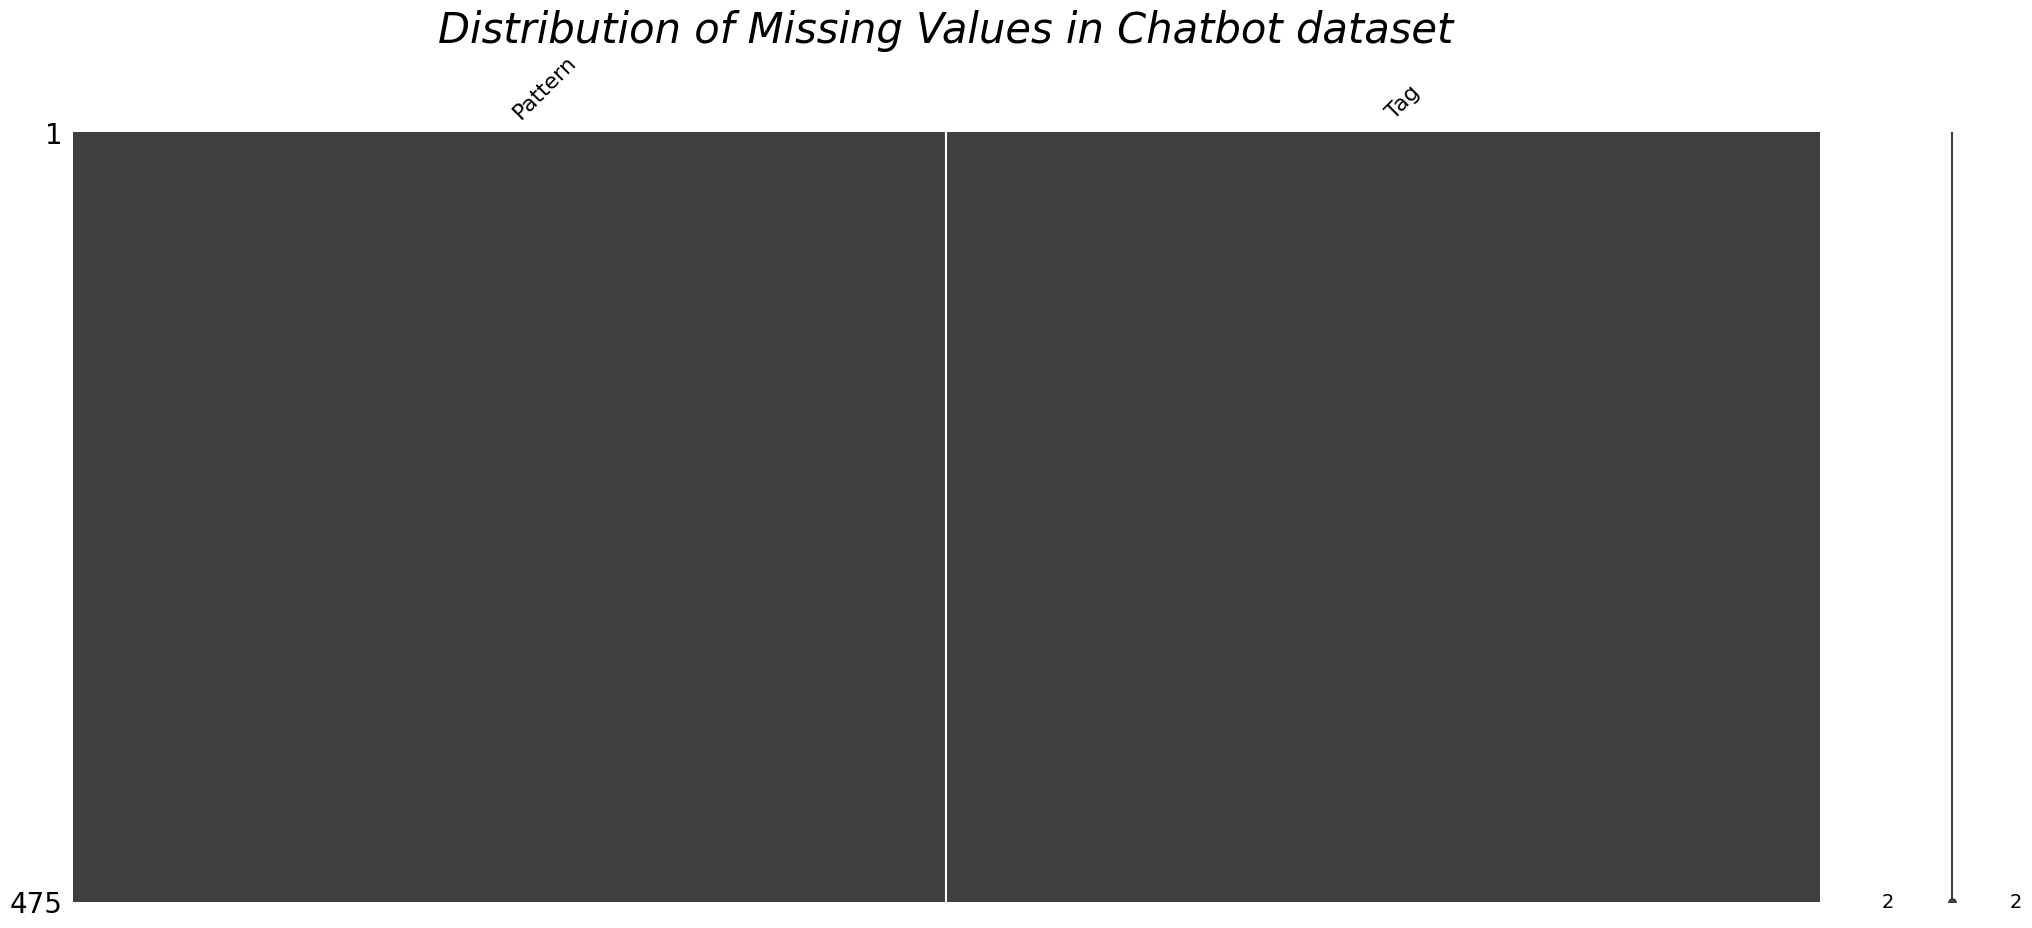

In [12]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

In [13]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

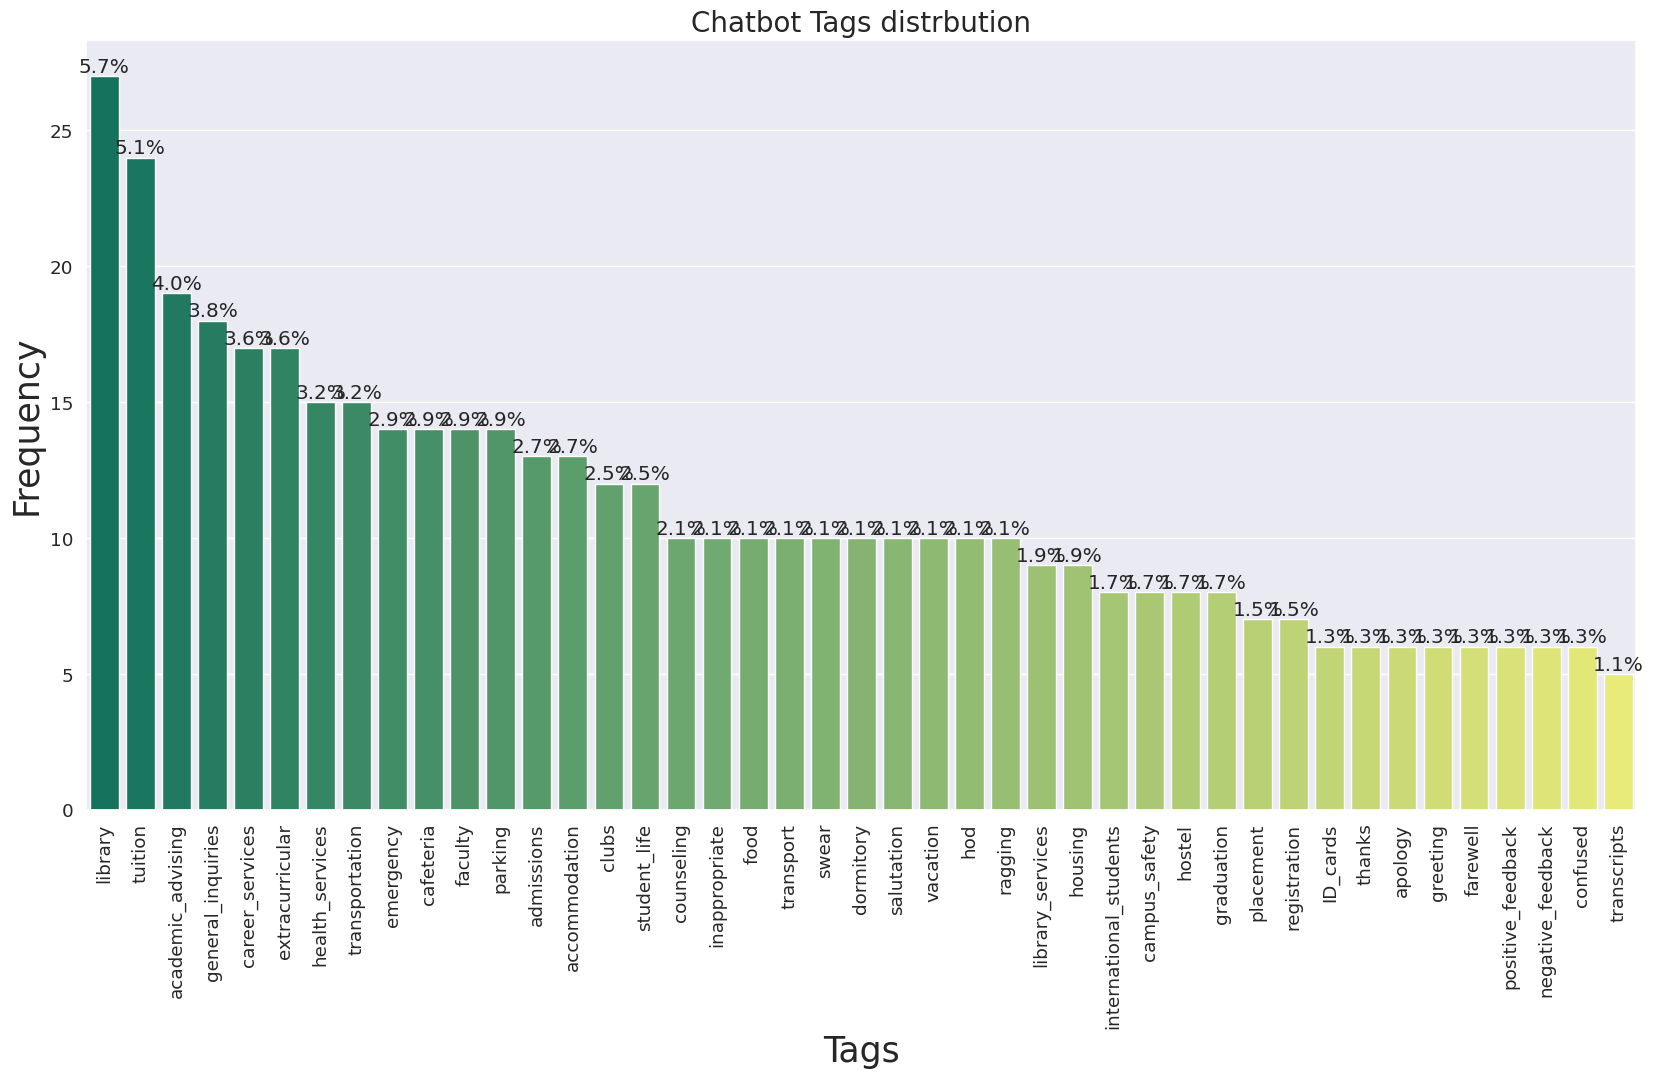

In [14]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [15]:
import nltk
nltk.download('punkt')

stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)
df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
df.head

<bound method NDFrame.head of                                      Pattern                Tag
0                 where is the univers locat  general_inquiries
1    can you provid the locat of the univers  general_inquiries
2         what 's the address of the univers  general_inquiries
3         how can i contact the admiss offic  general_inquiries
4      what is the contact inform for admiss  general_inquiries
..                                       ...                ...
470                          can you clarifi           confused
471                              i 'm confus           confused
472                         what do you mean           confused
473                          that 's unclear           confused
474                  can you explain further           confused

[475 rows x 2 columns]>

In [17]:
print(df['Pattern'].isnull().sum())

0


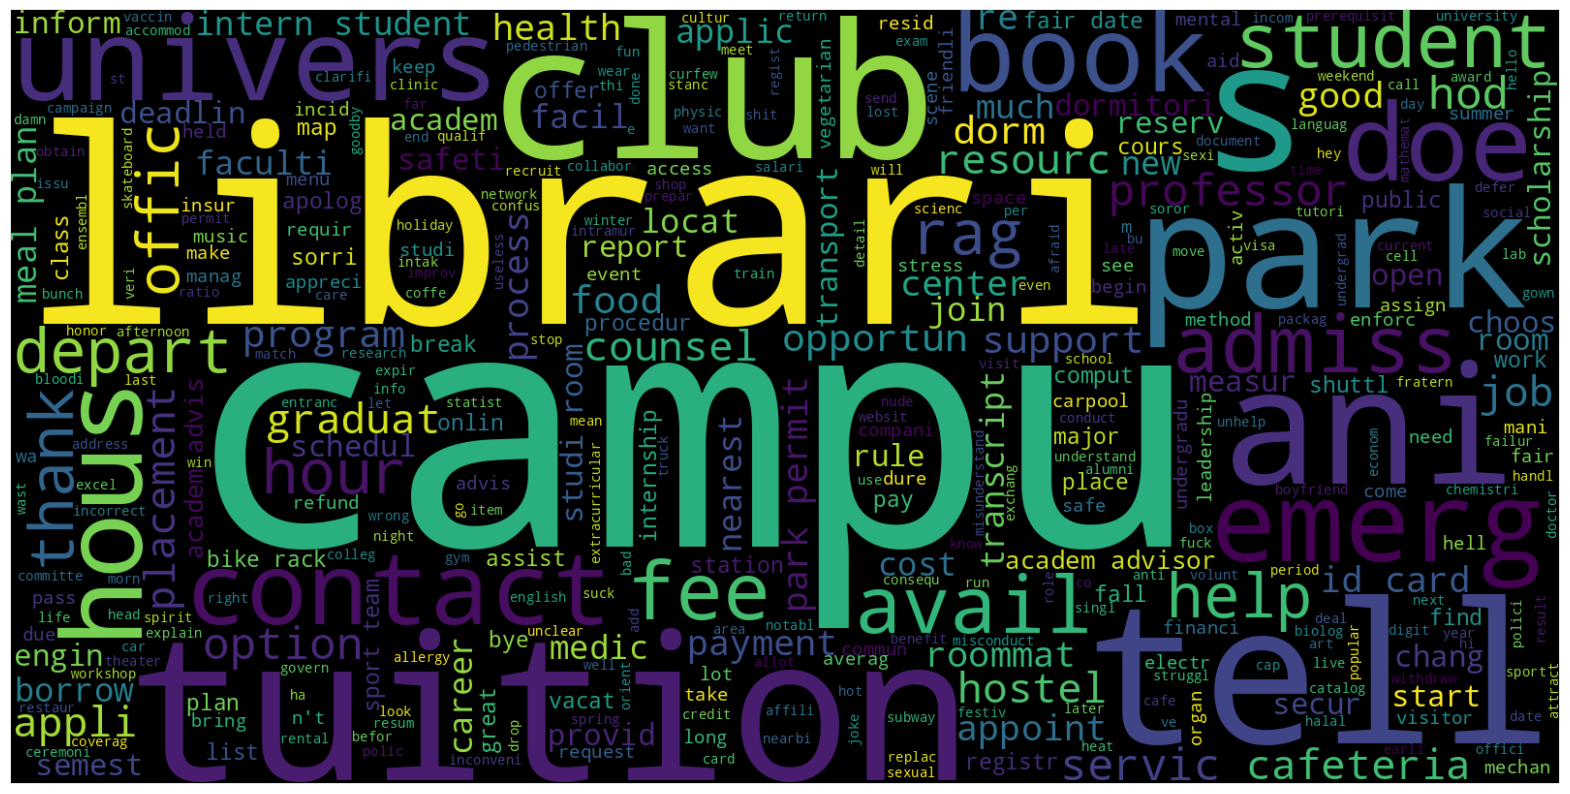

In [18]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

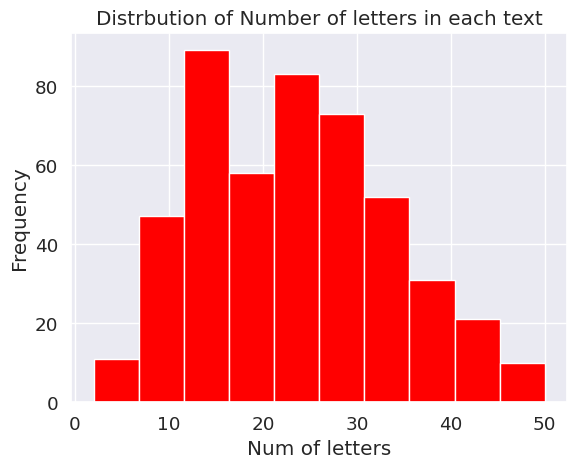

In [19]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

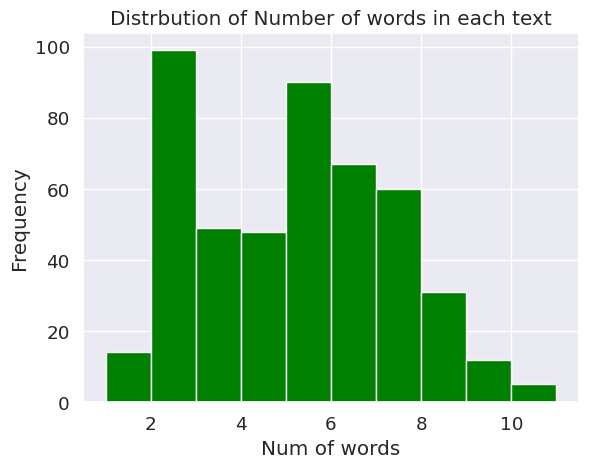

In [20]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

<ipython-input-21-c5010b3a990f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,color='red')


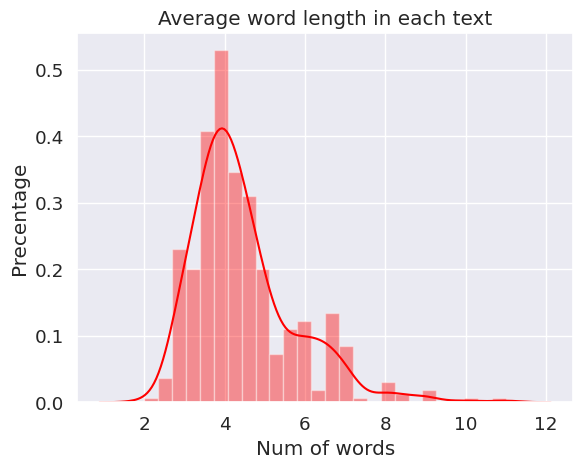

In [21]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [22]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['where', 'is', 'the', 'univers', 'locat']

In [23]:
print(f"dataset contains {len(corpus)} words")

dataset contains 2230 words


In [24]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'the': 146,
 'is': 75,
 'are': 67,
 'a': 65,
 'i': 63,
 'how': 61,
 'what': 55,
 'there': 53,
 'for': 52,
 'can': 45}

In [25]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

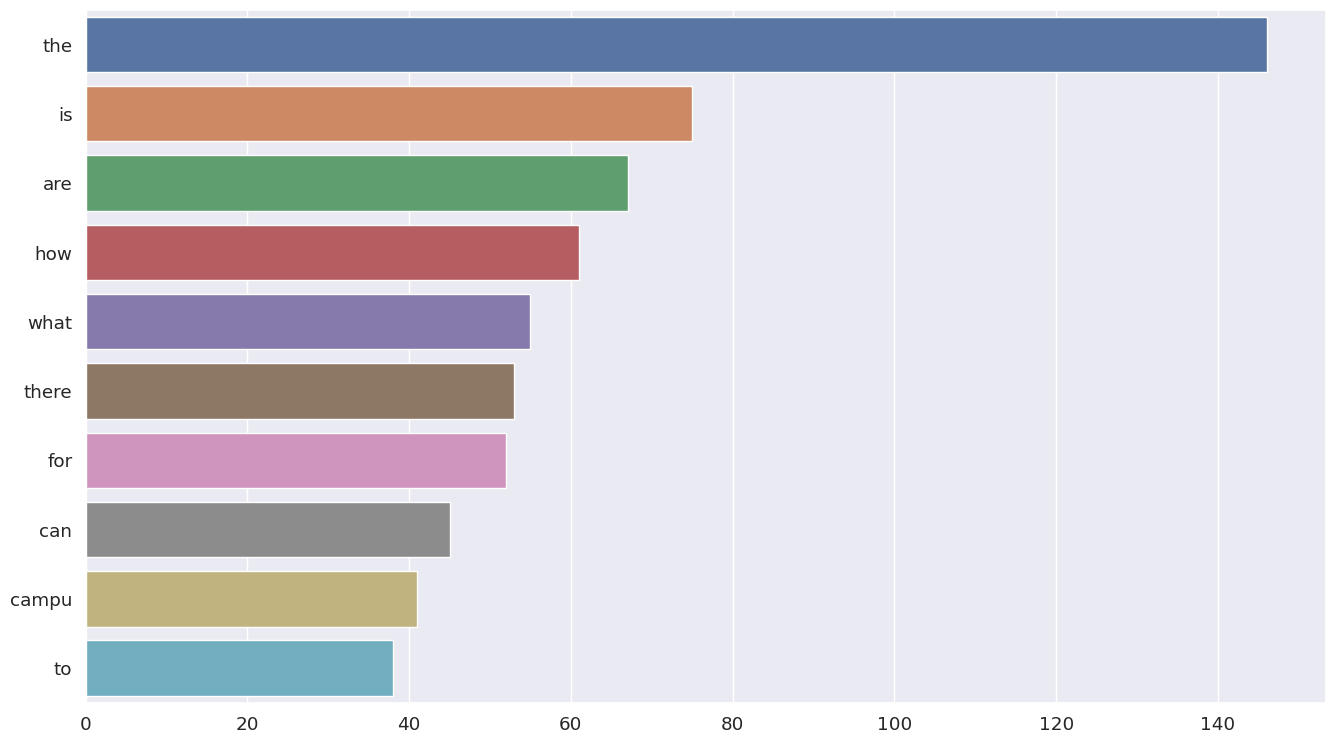

In [26]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

# Data  PreProcessing

In [27]:
df2.head()

,Pattern,Tag
0,Where is the university located?,general_inquiries
1,Can you provide the location of the university?,general_inquiries
2,What's the address of the university?,general_inquiries
3,How can I contact the admissions office?,general_inquiries
4,What is the contact information for admissions?,general_inquiries


In [28]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['general_inquiries',
 'faculty',
 'accommodation',
 'student_life',
 'admissions',
 'career_services',
 'campus_safety',
 'library_services',
 'health_services',
 'dormitory',
 'extracurricular',
 'international_students',
 'academic_advising',
 'transportation',
 'ragging',
 'hod',
 'salutation',
 'vacation',
 'swear',
 'inappropriate',
 'library',
 'transport',
 'food',
 'hostel',
 'placement',
 'cafeteria',
 'tuition',
 'emergency',
 'parking',
 'clubs',
 'counseling',
 'housing',
 'registration',
 'transcripts',
 'ID_cards',
 'graduation',
 'thanks',
 'apology',
 'greeting',
 'farewell',
 'positive_feedback',
 'negative_feedback',
 'confused']

In [29]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [30]:
id2label

{0: 'general_inquiries',
 1: 'faculty',
 2: 'accommodation',
 3: 'student_life',
 4: 'admissions',
 5: 'career_services',
 6: 'campus_safety',
 7: 'library_services',
 8: 'health_services',
 9: 'dormitory',
 10: 'extracurricular',
 11: 'international_students',
 12: 'academic_advising',
 13: 'transportation',
 14: 'ragging',
 15: 'hod',
 16: 'salutation',
 17: 'vacation',
 18: 'swear',
 19: 'inappropriate',
 20: 'library',
 21: 'transport',
 22: 'food',
 23: 'hostel',
 24: 'placement',
 25: 'cafeteria',
 26: 'tuition',
 27: 'emergency',
 28: 'parking',
 29: 'clubs',
 30: 'counseling',
 31: 'housing',
 32: 'registration',
 33: 'transcripts',
 34: 'ID_cards',
 35: 'graduation',
 36: 'thanks',
 37: 'apology',
 38: 'greeting',
 39: 'farewell',
 40: 'positive_feedback',
 41: 'negative_feedback',
 42: 'confused'}

In [31]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Where is the university located?,general_inquiries,0
1,Can you provide the location of the university?,general_inquiries,0
2,What's the address of the university?,general_inquiries,0
3,How can I contact the admissions office?,general_inquiries,0
4,What is the contact information for admissions?,general_inquiries,0


# Train Test Splitting

In [32]:
X = list(df2['Pattern'])
X[:5]

['Where is the university located?',
 'Can you provide the location of the university?',
 "What's the address of the university?",
 'How can I contact the admissions office?',
 'What is the contact information for admissions?']

In [33]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

# Loading BERT

In [35]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Transforming Data Into Numerical Format

In [36]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)
full_data = tokenizer(X, truncation=True, padding=True)

# Building Data Loader

In [37]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [38]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [39]:
fullDataLoader = DataLoader(full_data, y_test)

# Defining Evaluation Metrics

In [40]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Defining Training Arguments

In [41]:
!pip install transformers[torch]
!pip install accelerate -U

In [42]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

# Training the Model

In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [44]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.662500,3.562102,0.126050,0.064533,0.077903,0.090873
100,2.967500,2.670352,0.436975,0.333934,0.341417,0.417054
150,1.646400,1.534570,0.689076,0.590124,0.630620,0.642636
200,0.675800,1.136917,0.722689,0.692215,0.728005,0.742063
250,0.264400,0.975323,0.739496,0.713860,0.751474,0.765873
300,0.112500,0.945971,0.756303,0.744319,0.790760,0.789683
350,0.069600,0.974295,0.739496,0.720764,0.756395,0.762791
400,0.071300,0.987281,0.731092,0.721294,0.773611,0.775397
450,0.048300,1.030296,0.722689,0.714183,0.760119,0.771429
500,0.044900,1.024720,0.756303,0.742448,0.790278,0.790873


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

TrainOutput(global_step=1200, training_loss=0.41574303557475406, metrics={'train_runtime': 179.6089, 'train_samples_per_second': 198.208, 'train_steps_per_second': 6.681, 'total_flos': 292818802598400.0, 'train_loss': 0.41574303557475406, 'epoch': 100.0})

# Evaluating The Model

In [45]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.030946,0.988764,0.988759,0.991791,0.987311
test,1.024720,0.756303,0.742448,0.790278,0.790873


In [46]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [47]:
text = "Hello"
predict(text)

(tensor([[4.3291e-04, 1.4841e-04, 7.9647e-04, 4.8436e-04, 4.8252e-04, 4.0672e-04,
          5.4903e-04, 1.8580e-04, 1.4491e-03, 1.5906e-04, 1.1022e-03, 4.0060e-04,
          2.7311e-04, 2.6749e-04, 4.2328e-04, 2.7497e-04, 1.1035e-04, 1.3751e-03,
          1.5138e-03, 1.3962e-03, 1.6306e-04, 8.4200e-05, 8.9065e-04, 7.5574e-05,
          2.3661e-04, 2.5413e-04, 1.3664e-04, 1.8729e-03, 1.9675e-04, 4.1955e-04,
          9.8193e-04, 2.1616e-04, 1.5574e-04, 4.0258e-04, 2.1689e-04, 8.0082e-04,
          3.8170e-04, 8.6096e-04, 9.7492e-01, 2.8277e-04, 2.2218e-03, 9.3703e-04,
          1.0630e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(38, device='cuda:0'),
 'greeting')

# Saving The Model

In [48]:
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /content


In [49]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [50]:
!pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 2.4 MB/s eta 0:00:00


# Loading The Model

In [51]:
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /content


In [52]:
model_path = "/content/chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Chatbot

In [67]:
label2id = {intent['tag']: idx for idx, intent in enumerate(intents)}

def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistant. Feel free to ask, and I'll do my best to provide you with answers and assistance.")
    print("Type 'quit' to exit the chat\n")

    text = input("User: ").strip().lower()

    while text != 'quit':

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry, I can't answer that\n")
            text = input("User: ").strip().lower()
            continue

        label = chatbot(text)[0]['label']  # Label is a string, not an index
        responses = [intent['responses'] for intent in intents if intent['tag'] == label]

        if responses:
            response = random.choice(responses[0])  # Randomly select a response from the list

            print(f"Chatbot: {response}\n")
        else:
            print("Chatbot: Sorry, I can't answer that\n")

        text = input("User: ").strip().lower()


In [68]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistant. Feel free to ask, and I'll do my best to provide you with answers and assistance.
Type 'quit' to exit the chat

User: hello
Chatbot: Hello!

User: how are you
Chatbot: Sorry, I can't answer that

User: hello how are you
Chatbot: Hey!

User: admission details
Chatbot: Sorry, I can't answer that

User: when do admissions open
Chatbot: You can apply for admission through our online portal.

User: when do admissions open
Chatbot: We have an entrance exam for some programs, the details of which can be found on our admissions page.

User: when do admissions open
Chatbot: Admissions usually open in the fall, with the exact dates updated on our website.

User: tell me about the university
Chatbot: Sorry, I can't answer that

User: library hours
Chatbot: Yes, there are computers available for use in the library.

User: study rooms?
Chatbot: Yes, many of the library's resources can be accessed online.

User: thanks :D
Chatbot: You're welcome!

User: quit